# XGBoost with Grid Search Setup
- Grid Search is used to find the best parameters for the model
- It is a brute force method that tries all the combinations of parameters to find the best combination [cv = n means (n-fold cross validation)]

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
#Grid Search
from sklearn.model_selection import GridSearchCV

# Load the cleaned dataset
df = pd.read_csv('../../../../Data/Creation/CSV/Combined_Log_Excl_Roil_Clean.csv')


df.head()

,date,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx,Real Oil Prices
0,1992-02,8.985233,8.838189,4.022992,13.540263,12.008920,4.126003,4.254484,4.229009,4.385748,...,4.063009,2.475698,2.615204,2.424803,4.231204,11.067669,12.153474,6.612267,2.836180,13.715729
1,1992-03,8.986886,8.839001,4.024816,13.544280,12.005919,4.134350,4.262926,4.237888,4.394678,...,4.065979,2.478218,2.621766,2.426571,4.330733,11.050763,12.159442,6.619469,2.786412,13.601725
2,1992-04,8.990617,8.841752,4.025655,13.550922,12.011936,4.142042,4.270416,4.245491,4.404083,...,4.069727,2.481568,2.622492,2.430099,4.346399,11.071004,12.159567,6.628021,2.784301,14.512195
3,1992-05,8.995945,8.847245,4.030801,13.542184,12.017403,4.145290,4.275880,4.251300,4.410553,...,4.070922,2.482404,2.622492,2.432736,4.371976,11.038303,12.159899,6.640681,2.689751,15.017895
4,1992-06,9.000118,8.851692,4.033497,13.552670,12.020207,4.145887,4.273481,4.248251,4.405713,...,4.072355,2.485740,2.630449,2.434490,4.387014,11.051223,12.169043,6.652466,2.691453,15.981442


### Convert date to year, day so that it can be used in the model.
- Regression models (like random forest) can't use date as a feature. So we convert it to year and day.

In [2]:
# Convert 'date' column to datetime objects
df['date'] = pd.to_datetime(df['date'], format='%Y-%m')

# Extract the year and month from the datetime object
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month


# Remove the date column
df.drop('date', axis=1, inplace=True)

df.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx,Real Oil Prices,year,month
0,8.985233,8.838189,4.022992,13.540263,12.008920,4.126003,4.254484,4.229009,4.385748,4.057705,...,2.615204,2.424803,4.231204,11.067669,12.153474,6.612267,2.836180,13.715729,1992,2
1,8.986886,8.839001,4.024816,13.544280,12.005919,4.134350,4.262926,4.237888,4.394678,4.078063,...,2.621766,2.426571,4.330733,11.050763,12.159442,6.619469,2.786412,13.601725,1992,3
2,8.990617,8.841752,4.025655,13.550922,12.011936,4.142042,4.270416,4.245491,4.404083,4.096502,...,2.622492,2.430099,4.346399,11.071004,12.159567,6.628021,2.784301,14.512195,1992,4
3,8.995945,8.847245,4.030801,13.542184,12.017403,4.145290,4.275880,4.251300,4.410553,4.127247,...,2.622492,2.432736,4.371976,11.038303,12.159899,6.640681,2.689751,15.017895,1992,5
4,9.000118,8.851692,4.033497,13.552670,12.020207,4.145887,4.273481,4.248251,4.405713,4.113261,...,2.630449,2.434490,4.387014,11.051223,12.169043,6.652466,2.691453,15.981442,1992,6


## Splitting the data into train and test sets

In [3]:
# Splitting the data into features and target
X = df.drop('Real Oil Prices', axis=1)
y = df['Real Oil Prices']

# Split the data into training and testing sets (80% for training and 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Grid Search to find the best parameters

In [4]:
# Define the hyperparameters and their possible values
param_grid = {
    'n_estimators': [10, 50, 100, 300],
    'learning_rate': [0.001, 0.01, 0.1, 0.3],
    'max_depth': [1, 2, 3, 5],
}

# Initialize the XGBoost regressor
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', seed=42)

# Set up the grid search
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Use the best model to make predictions
best_xgb_model = grid_search.best_estimator_
predictions = best_xgb_model.predict(X_test)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


Best parameters found:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}


## Evaluating the model with best parameters

In [5]:
# Evaluate the model
xgb_mae = mean_absolute_error(y_test, predictions)
xgb_mse = mean_squared_error(y_test, predictions)
xgb_r2 = r2_score(y_test, predictions)
xgb_mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
xgb_rmse = np.sqrt(xgb_mse)

print(f"XGBoost Mean Absolute Error: {xgb_mae}")
print(f"XGBoost Mean Squared Error: {xgb_mse}")
print(f"XGBoost Root Mean Squared Error: {xgb_rmse}")
print(f"XGBoost R2 Score: {xgb_r2}")
print(f"XGBoost MAPE: {xgb_mape}")

XGBoost Mean Absolute Error: 1.5993336767965411
XGBoost Mean Squared Error: 4.119573219557369
XGBoost Root Mean Squared Error: 2.0296731804794015
XGBoost R2 Score: 0.9603104542344614
XGBoost MAPE: 8.008280994983403


## Feature Importance

<Figure size 1000x1200 with 0 Axes>

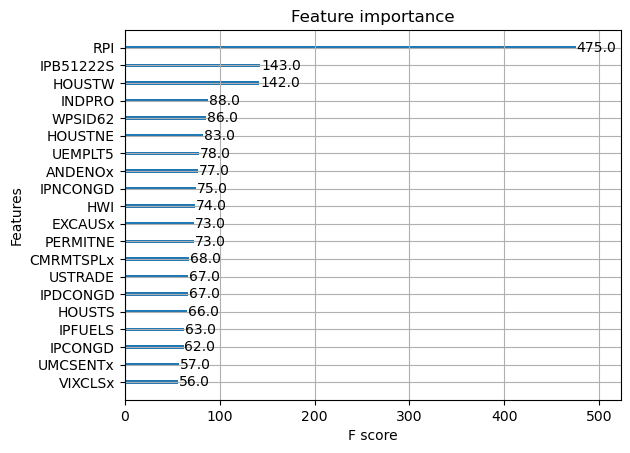

In [6]:
# Plotting feature importances for the best model
plt.figure(figsize=(10, 12))
plot_importance(best_xgb_model, max_num_features=20)
plt.show()

## Actual vs Predicted

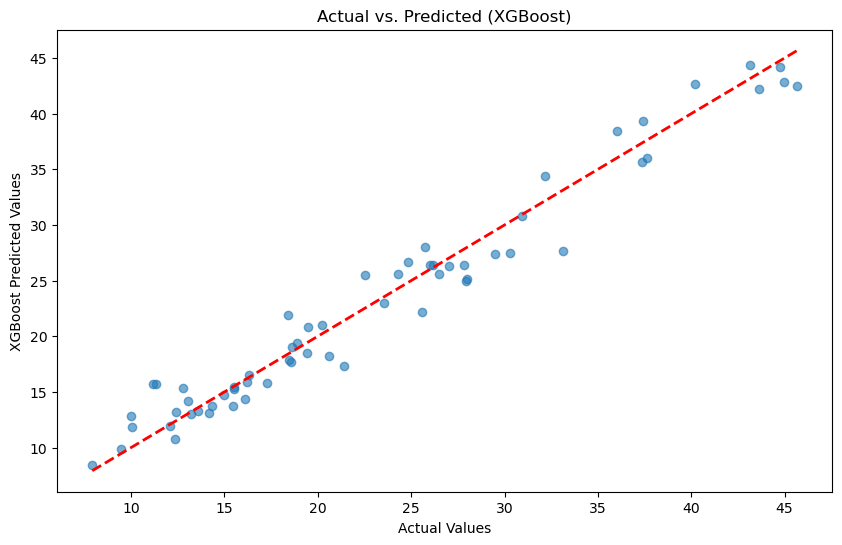

In [7]:
# Actual vs. Predicted scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('XGBoost Predicted Values')
plt.title('Actual vs. Predicted (XGBoost)')
plt.show()

### Learning Curve

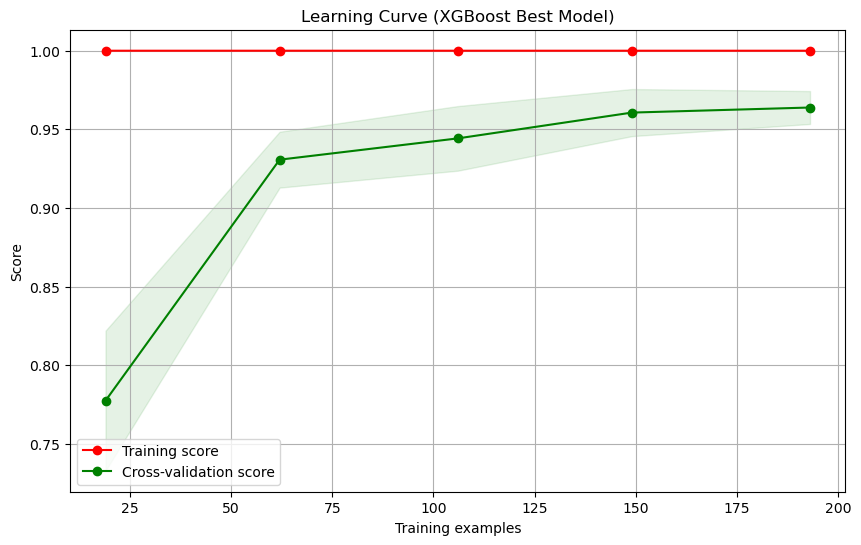

In [8]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    # Fill between lines to indicate standard deviation
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # Plot the average training and test scores
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot the learning curve for the XGBoost model
plot_learning_curve(best_xgb_model, "Learning Curve (XGBoost Best Model)", X_train, y_train, cv=5)
plt.show()

- The Training score curve (in red) shows how the model's performance on the training data changes as more data is used.
- The Cross-validation score curve (in green) shows how the model's performance on a validation set changes as more training data is used.